Using device: cpu
n=  1 | mean NN distance ≈ 0.0005  (± 0.0000 over 5 trials)
n=  2 | mean NN distance ≈ 0.0161  (± 0.0001 over 5 trials)
n=  5 | mean NN distance ≈ 0.1786  (± 0.0025 over 5 trials)
n= 10 | mean NN distance ≈ 0.5084  (± 0.0036 over 5 trials)
n= 20 | mean NN distance ≈ 1.0410  (± 0.0052 over 5 trials)
n= 50 | mean NN distance ≈ 2.1229  (± 0.0035 over 5 trials)
n=100 | mean NN distance ≈ 3.3229  (± 0.0044 over 5 trials)


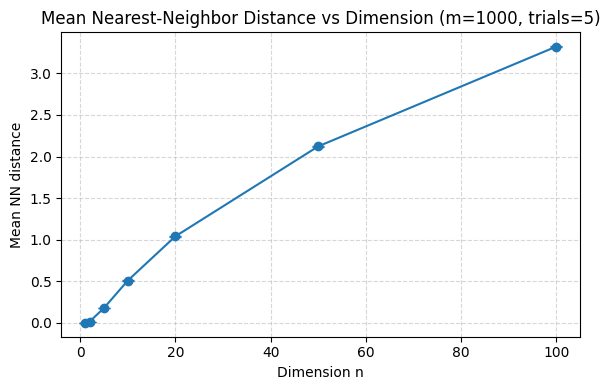

In [2]:


# Monte Carlo: mean nearest-neighbor distance vs dimension
# Uses PyTorch for sampling & distance calc; matplotlib for plotting.

import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

def mean_nn_distance_for_dimension(n: int, m: int, device="cpu") -> float:
    """
    Draw m points ~ Unif([0,1]^n), compute each point's nearest-neighbor distance,
    and return the mean NN distance.
    """
    # Sample (m, n) from [0,1]^n
    X = torch.rand((m, n), device=device)

    # Pairwise Euclidean distances (m, m)
    D = torch.cdist(X, X, p=2)

    # Exclude self-distances
    inf = torch.tensor(float("inf"), device=device)
    D.fill_diagonal_(inf)

    # Nearest neighbor distance per point, then mean
    nn_dist, _ = torch.min(D, dim=1)
    return float(nn_dist.mean().item())

def run_experiment(n_list, m=1000, trials=5, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    means = []
    stds  = []

    with torch.no_grad():
        for n in n_list:
            vals = [mean_nn_distance_for_dimension(n, m, device=device) for _ in range(trials)]
            vals_t = torch.tensor(vals)
            means.append(vals_t.mean().item())
            stds.append(vals_t.std(unbiased=True).item())

    return means, stds, device

# ----- Configure your experiment here -----
n_list  = [1, 2, 5, 10, 20, 50, 100]
m       = 1000     # points per dimension
trials  = 5        # repetitions per dimension

means, stds, device = run_experiment(n_list, m=m, trials=trials)

# Print a small table
for n, mu, sd in zip(n_list, means, stds):
    print(f"n={n:>3d} | mean NN distance ≈ {mu:.4f}  (± {sd:.4f} over {trials} trials)")

# ----- Plot -----
plt.figure(figsize=(6,4))
# error bars are optional; comment out yerr=stds if you prefer a clean line
plt.errorbar(n_list, means, yerr=stds, marker="o", capsize=4)
plt.title(f"Mean Nearest-Neighbor Distance vs Dimension (m={m}, trials={trials})")
plt.xlabel("Dimension n")
plt.ylabel("Mean NN distance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()



# Monte Carlo: Curse of Dimensionality

**Goal:** With fixed m, show mean nearest-neighbor (NN) distance increases as dimension n grows.

**Method (per n ∈ {1,2,5,10,20,50,100}):**
- Sample X ~ Uniform([0,1]^n) using `torch.rand` (m points).
- Compute pairwise distances with basic tensor ops:
  ||xi−xj||² = ||xi||² + ||xj||² − 2 xiᵀxj.
- Mask diagonal (∞), take row-wise mins (NN), average over points.
- Repeat a few trials; plot mean NN vs n.

**Why it works:** In high-D, points spread out → neighbors are farther → mean NN ↑.

**Params:** m = __; trials = __.

**Result:** Mean NN distance rises with n (plot confirms).
